<a href="https://colab.research.google.com/github/suresh-venkate/Code_Repositories/blob/main/Deep_Learning/Natural_Language_Processing/Transformer_Models/Transformer_From_Scratch/Transformer_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer from scratch

* Reference: Attention is all you need, NIPS 2017
* Authors: Ashish Vaswani et.al.
* Link to paper: [Link](https://arxiv.org/abs/1706.03762)
* All references in the code below refer to this paper unless stated otherwise

# Import required libraries

In [1]:
%%capture 
!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Natural_Language_Processing/Transformer_Models/Transformer_From_Scratch/transformer_utils.py
!pip install torchsummaryX

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math, copy, time
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torchsummary import summary as ts_summary
from torchsummaryX import summary as summaryx
from transformer_utils import *

# Backup

## Verify Function: clones

In [3]:
class TempModel(nn.Module):
  def __init__(self, layer, N):
    super(TempModel, self).__init__()
    self.layers = clones(layer, N)

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

device = "cuda" if torch.cuda.is_available() else "cpu"
lin_layer = nn.Linear(128, 128)
temp_model = TempModel(lin_layer, 4).to(device) # Clone linear layer 4 times
ts_summary(temp_model, input_size = (128,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          16,512
            Linear-2                  [-1, 128]          16,512
            Linear-3                  [-1, 128]          16,512
            Linear-4                  [-1, 128]          16,512
Total params: 66,048
Trainable params: 66,048
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.25
Estimated Total Size (MB): 0.26
----------------------------------------------------------------


## Verify Class: Embeddings

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
src_vocab = 11 # 0 to 10
d_model = 512
nb = 2 # Batch Size
nw = 5 # Number of words (or positions) in the input
temp_model = Embeddings(d_model, src_vocab).to(device)

# Generate nw input samples of length 10 each
input = torch.randint(0, 10, (nb, nw)).to(device)
output = temp_model(input)

print(input.shape, output.shape)

torch.Size([2, 5]) torch.Size([2, 5, 512])


In [5]:
input_size = (2, 5)
x_sample = torch.zeros(input_size, dtype=torch.long, device=torch.device('cuda'))
summaryx(temp_model, x_sample)

      Kernel Shape Output Shape  Params  Mult-Adds
Layer                                             
0_emb    [512, 11]  [2, 5, 512]    5632       5632
--------------------------------------------------
                      Totals
Total params            5632
Trainable params        5632
Non-trainable params       0
Mult-Adds               5632


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_emb,"[512, 11]","[2, 5, 512]",5632,5632


## Verify Class: PositionalEncoding

torch.Size([1, 100, 20]) torch.Size([1, 100, 20])


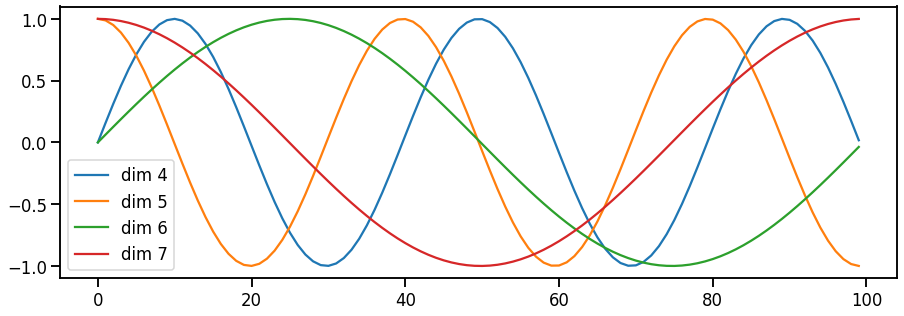

In [6]:
d_model = 20 # Embedding Size
nb = 1 # Batch Size
nw = 100 # Number of words (or positions) in the input
pe = PositionalEncoding(d_model, dropout = 0)
input = torch.zeros(nb, nw, d_model)
output = pe.forward(input)

print(input.shape, output.shape)
plt.figure(figsize=(15, 5))
plt.plot(np.arange(100), output[0, :, 4:8].numpy())
plt.legend(["dim %d" %p for p in [4, 5, 6, 7]])
plt.show()

## Verify Class: ScaledDotProductAttention

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

nb = 2 # Batch Size
h = 8 # Number of attention heads
nw = 5 # Number of words (or positions) in the input
dk = 64 # Dimension of Q, K and V vectors
scaling = dk ** 0.5

attn_dropout = nn.Dropout(p = 0) # Define dropout layer

temp_model = ScaledDotProductAttention(scaling).to(device) # SDPA layer

Q = torch.randint(low = 0, high = 10, size = (nb, h, nw, dk), dtype = torch.float32)
K = torch.clone(Q)
V = torch.clone(Q)

attn, probs = temp_model(Q, K, V, None, attn_dropout)
attn = torch.round(attn)

print(Q.shape, attn.shape, probs.shape)
print()
print(Q[0, 0, :, :5])
print()
print(probs[0, 0])
print()
print(attn[0, 0, :, :5])

torch.Size([2, 8, 5, 64]) torch.Size([2, 8, 5, 64]) torch.Size([2, 8, 5, 5])

tensor([[4., 5., 8., 1., 2.],
        [7., 2., 9., 2., 3.],
        [2., 3., 5., 6., 9.],
        [1., 8., 0., 6., 3.],
        [8., 2., 8., 6., 5.]])

tensor([[1.0000e+00, 6.8196e-27, 3.2213e-27, 5.5211e-42, 3.3953e-28],
        [2.1556e-36, 1.0000e+00, 1.5928e-35, 5.6317e-40, 8.5846e-29],
        [1.7362e-20, 2.7159e-19, 1.0000e+00, 7.8281e-32, 1.7021e-22],
        [5.3802e-32, 1.7362e-20, 1.4154e-28, 1.0000e+00, 3.4188e-21],
        [1.4056e-35, 1.1244e-26, 1.3074e-36, 1.4524e-38, 1.0000e+00]])

tensor([[4., 5., 8., 1., 2.],
        [7., 2., 9., 2., 3.],
        [2., 3., 5., 6., 9.],
        [1., 8., 0., 6., 3.],
        [8., 2., 8., 6., 5.]])


## Verify Class: MultiHeadAttention


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

nb = 2 # Batch Size
h = 8 # Number of attention heads
nw = 5 # Number of words (or positions) in the input
dk = 64 # Dimension of Q, K and V vectors
d_model = h * dk

temp_model = MultiHeadAttention(h = h, d_model = 512, attn_dropout = 0.0).to(device)

Q = torch.randint(0, 10, (nb, nw, (h * dk)), dtype = torch.float32).to(device)
K = torch.clone(Q)
V = torch.clone(Q)

x = temp_model(Q, K, V, mask = None)
print(Q.shape, x.shape, temp_model.attn.shape)

torch.Size([2, 5, 512]) torch.Size([2, 5, 512]) torch.Size([2, 8, 5, 5])


## Verify Class: (MultiHeadAttention + AddAndNorm)


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
nb = 2 # Batch Size
h = 8 # Number of attention heads
nw = 5 # Number of words (or positions) in the input
dk = 64 # Dimension of Q, K and V vectors
d_model = h * dk

attn = MultiHeadAttention(h = h, d_model = d_model, attn_dropout = 0.0).to(device)
addandnorm = AddAndNorm(d_model).to(device)

x = torch.randint(0, 10, (nb, nw, (h * dk)), dtype = torch.float32).to(device)
print(x.shape)
x = addandnorm(x, lambda x: attn(x, x, x))
print(x.shape)

torch.Size([2, 5, 512])
torch.Size([2, 5, 512])


## Verify Class: Position-Wise Feed-Forward

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
d_model = 512 # Embedding Size
d_ff = 2048 # Intermediate Layer Size
PWFFN = PositionwiseFeedForward(d_model, d_ff, 0.0).to(device)
ts_summary(PWFFN, input_size = (5, d_model,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 5, 2048]       1,050,624
              ReLU-2              [-1, 5, 2048]               0
            Linear-3               [-1, 5, 512]       1,049,088
           Dropout-4               [-1, 5, 512]               0
Total params: 2,099,712
Trainable params: 2,099,712
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.20
Params size (MB): 8.01
Estimated Total Size (MB): 8.21
----------------------------------------------------------------


In [11]:
nb = 2 # Batch Size
nw = 5 # Number of words (or positions) in the input
d_model = 512
input = torch.randint(0, 10, (nb, nw, d_model), dtype = torch.float32).to(device)
output = PWFFN(input)
print(input.shape, output.shape)

torch.Size([2, 5, 512]) torch.Size([2, 5, 512])


## Verify Class: EncoderLayer

In [12]:
d_model = 512 # Embedding Size
h = 8 # Number of attention heads
d_ff = 2048 # Intermediate Layer Size
enc_layer = EncoderLayer(d_model, h, d_ff, 0, 0).to(device)
ts_summary(enc_layer, input_size = (5, d_model,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 5, 512]         262,144
            Linear-2               [-1, 5, 512]         262,144
            Linear-3               [-1, 5, 512]         262,144
           Softmax-4              [-1, 8, 5, 5]               0
           Dropout-5              [-1, 8, 5, 5]               0
ScaledDotProductAttention-6  [[-1, 8, 5, 64], [-1, 8, 5, 5]]               0
            Linear-7               [-1, 5, 512]         262,144
           Dropout-8               [-1, 5, 512]               0
MultiHeadAttention-9               [-1, 5, 512]               0
        LayerNorm-10               [-1, 5, 512]           1,024
       AddAndNorm-11               [-1, 5, 512]               0
           Linear-12              [-1, 5, 2048]       1,050,624
             ReLU-13              [-1, 5, 2048]               0
           Linear-14      

## Verify Class: Encoder

In [13]:
d_model = 512 # Embedding Size
h = 8 # Number of attention heads
d_ff = 2048 # Intermediate Layer Size
N = 6 # Number of encoder layers
enc = Encoder(d_model, h, d_ff, 0, 0, 6).to(device)
ts_summary(enc, input_size = (5, d_model,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1               [-1, 5, 512]           1,024
            Linear-2               [-1, 5, 512]         262,144
            Linear-3               [-1, 5, 512]         262,144
            Linear-4               [-1, 5, 512]         262,144
           Softmax-5              [-1, 8, 5, 5]               0
           Dropout-6              [-1, 8, 5, 5]               0
ScaledDotProductAttention-7  [[-1, 8, 5, 64], [-1, 8, 5, 5]]               0
            Linear-8               [-1, 5, 512]         262,144
           Dropout-9               [-1, 5, 512]               0
MultiHeadAttention-10               [-1, 5, 512]               0
        LayerNorm-11               [-1, 5, 512]           1,024
       AddAndNorm-12               [-1, 5, 512]               0
           Linear-13              [-1, 5, 2048]       1,050,624
             ReLU-14     

## Verify Class: DecoderLayer

In [14]:
d_model = 512 # Embedding Size
h = 8 # Number of attention heads
d_ff = 2048 # Intermediate Layer Size
dec_layer = DecoderLayer(d_model, h, d_ff, 0, 0).to(device)
ts_summary(dec_layer, input_size = [(5, d_model), (5, d_model)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 5, 512]         262,144
            Linear-2               [-1, 5, 512]         262,144
            Linear-3               [-1, 5, 512]         262,144
           Softmax-4              [-1, 8, 5, 5]               0
           Dropout-5              [-1, 8, 5, 5]               0
ScaledDotProductAttention-6  [[-1, 8, 5, 64], [-1, 8, 5, 5]]               0
            Linear-7               [-1, 5, 512]         262,144
           Dropout-8               [-1, 5, 512]               0
MultiHeadAttention-9               [-1, 5, 512]               0
        LayerNorm-10               [-1, 5, 512]           1,024
       AddAndNorm-11               [-1, 5, 512]               0
           Linear-12               [-1, 5, 512]         262,144
           Linear-13               [-1, 5, 512]         262,144
           Linear-14      

## Verify Class: Decoder

In [15]:
d_model = 512 # Embedding Size
h = 8 # Number of attention heads
d_ff = 2048 # Intermediate Layer Size
N = 6 # Number of decoder layers
dec = Decoder(d_model, h, d_ff, 0, 0, N).to(device)
ts_summary(dec, input_size = [(5, d_model), (5, d_model)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1               [-1, 5, 512]           1,024
            Linear-2               [-1, 5, 512]         262,144
            Linear-3               [-1, 5, 512]         262,144
            Linear-4               [-1, 5, 512]         262,144
           Softmax-5              [-1, 8, 5, 5]               0
           Dropout-6              [-1, 8, 5, 5]               0
ScaledDotProductAttention-7  [[-1, 8, 5, 64], [-1, 8, 5, 5]]               0
            Linear-8               [-1, 5, 512]         262,144
           Dropout-9               [-1, 5, 512]               0
MultiHeadAttention-10               [-1, 5, 512]               0
        LayerNorm-11               [-1, 5, 512]           1,024
       AddAndNorm-12               [-1, 5, 512]               0
           Linear-13               [-1, 5, 512]         262,144
           Linear-14     

## Verify Class: Generator

In [16]:
d_model = 512 # Embedding Size
vocab = 11 # Size of vocabulary
gen = Generator(d_model, vocab).to(device) # Generator instance
ts_summary(gen, input_size = (5, d_model))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 5, 11]           5,643
        LogSoftmax-2                [-1, 5, 11]               0
Total params: 5,643
Trainable params: 5,643
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


## Verify Class: EncoderDecoder

In [17]:
d_model = 512 # Embedding Size
h = 8 # Number of attention heads
d_ff = 2048 # Intermediate Layer Size
N = 6 # Number of encoder layers
enc = Encoder(d_model, h, d_ff, 0, 0, N).to(device)
dec = Decoder(d_model, h, d_ff, 0, 0, N).to(device)

src_vocab = 11 # Size of source vocab vector
tgt_vocab = 11 # Size of target vocab vector
emb_enc = Embeddings(d_model, src_vocab).to(device)
emb_dec = Embeddings(d_model, tgt_vocab).to(device)
gen = Generator(d_model, tgt_vocab).to(device) # Generator instance

model = EncoderDecoder(enc, dec, emb_enc, emb_dec, gen)

input_size = (2, 5)
x_sample = torch.zeros(input_size, dtype=torch.long, device=torch.device('cuda'))
summaryx(model, x_sample, x_sample)

/usr/local/lib/python3.7/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


                                                   Kernel Shape  Output Shape  \
Layer                                                                           
0_src_embed.Embedding_emb                             [512, 11]   [2, 5, 512]   
1_encoder.LayerNorm_norm                                  [512]   [2, 5, 512]   
2_encoder.enclayer_stack.0.MHA_unit.Linear_wi_q      [512, 512]   [2, 5, 512]   
3_encoder.enclayer_stack.0.MHA_unit.Linear_wi_k      [512, 512]   [2, 5, 512]   
4_encoder.enclayer_stack.0.MHA_unit.Linear_wi_v      [512, 512]   [2, 5, 512]   
5_encoder.enclayer_stack.0.MHA_unit.sdpa.Softma...            -  [2, 8, 5, 5]   
6_encoder.enclayer_stack.0.MHA_unit.Dropout_dro...            -  [2, 8, 5, 5]   
7_encoder.enclayer_stack.0.MHA_unit.Linear_fc        [512, 512]   [2, 5, 512]   
8_encoder.enclayer_stack.0.MHA_unit.Dropout_dro...            -   [2, 5, 512]   
9_encoder.enclayer_stack.0.addandnorm_MHA.Layer...        [512]   [2, 5, 512]   
10_encoder.enclayer_stack.0.

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_src_embed.Embedding_emb,"[512, 11]","[2, 5, 512]",5632.0,5632.0
1_encoder.LayerNorm_norm,[512],"[2, 5, 512]",1024.0,512.0
2_encoder.enclayer_stack.0.MHA_unit.Linear_wi_q,"[512, 512]","[2, 5, 512]",262144.0,262144.0
3_encoder.enclayer_stack.0.MHA_unit.Linear_wi_k,"[512, 512]","[2, 5, 512]",262144.0,262144.0
4_encoder.enclayer_stack.0.MHA_unit.Linear_wi_v,"[512, 512]","[2, 5, 512]",262144.0,262144.0
...,...,...,...,...
203_decoder.declayer_stack.5.PWFFN.Linear_fc_1,"[512, 2048]","[2, 5, 2048]",1050624.0,1048576.0
204_decoder.declayer_stack.5.PWFFN.ReLU_relu,-,"[2, 5, 2048]",NaN,NaN
205_decoder.declayer_stack.5.PWFFN.Linear_fc_2,"[2048, 512]","[2, 5, 512]",1049088.0,1048576.0


# Backup_1

## Define classes and Functions

In [18]:
# # Small example model.
# tmp_model = make_model(10, 10, 2)
# tmp_model

In [19]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [20]:
# plt.figure(figsize=(5,5))
# plt.imshow(subsequent_mask(20)[0])
# None

In [21]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [22]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [23]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [24]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [25]:
# # Three settings of the lrate hyperparameters.
# opts = [NoamOpt(512, 1, 4000, None), 
#         NoamOpt(512, 1, 8000, None),
#         NoamOpt(256, 1, 4000, None)]
# plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
# plt.legend(["512:4000", "512:8000", "256:4000"])
# None

In [26]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

In [27]:
# #Example of label smoothing.
# crit = LabelSmoothing(5, 0, 0.4)
# predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
#                              [0, 0.2, 0.7, 0.1, 0], 
#                              [0, 0.2, 0.7, 0.1, 0]])
# v = crit(Variable(predict.log()), 
#          Variable(torch.LongTensor([2, 1, 0])))

# # Show the target distributions expected by the system.
# plt.imshow(crit.true_dist)
# None

In [28]:
# crit = LabelSmoothing(5, 0, 0.1)
# def loss(x):
#     d = x + 3 * 1
#     predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
#                                  ])
#     #print(predict)
#     return crit(Variable(predict.log()),
#                  Variable(torch.LongTensor([1]))).item()
# plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
# None

## Synthetic Data

In [29]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

## Loss Computation

In [30]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        #return loss.data[0] * norm
        return loss.item() * norm

## Greedy Decoding

In [31]:
V = 11
model = make_model(V, V, N=2)
data_iter = data_gen(V, 2, 1)
for i, batch in enumerate(data_iter):
  #print(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
  print(batch.src.shape, batch.trg.shape, batch.src_mask.shape, batch.trg_mask.shape)

torch.Size([2, 10]) torch.Size([2, 9]) torch.Size([2, 1, 10]) torch.Size([2, 9, 9])


/content/transformer_utils.py:451: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


In [ ]:
print(batch.src)
print(batch.trg)
print(batch.src_mask)
print(batch.trg_mask)

In [ ]:
batch.src_mask

In [ ]:
print(batch.src)
print(batch.trg)

In [32]:
enc_out = model.encode(batch.src, batch.src_mask)
print(enc_out.shape)

torch.Size([2, 10, 512])


In [33]:
emb_tgt = model.tgt_embed(batch.trg)
#model.decoder.declayer(emb_tgt, enc_out, batch.src_mask, batch.trg_mask)
layer = model.decoder.declayer.self_MHA_unit.sdpa
x = emb_tgt
layer(x, x, x, batch.src_mask)

RuntimeError: ignored

In [ ]:
model.decode(batch.trg, enc_out, batch.src_mask, batch.trg_mask)

In [34]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/content/transformer_utils.py:451: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


Epoch Step: 1 Loss: 3.271187 Tokens per Sec: 429.255920
Epoch Step: 1 Loss: 1.921017 Tokens per Sec: 579.715942
tensor(1.9087)
Epoch Step: 1 Loss: 1.845874 Tokens per Sec: 477.798828
Epoch Step: 1 Loss: 1.748855 Tokens per Sec: 402.966034
tensor(1.7128)
Epoch Step: 1 Loss: 1.907193 Tokens per Sec: 486.636841
Epoch Step: 1 Loss: 1.464710 Tokens per Sec: 569.645081
tensor(1.4500)
Epoch Step: 1 Loss: 2.099236 Tokens per Sec: 481.579163
Epoch Step: 1 Loss: 1.196683 Tokens per Sec: 586.728394
tensor(1.1900)
Epoch Step: 1 Loss: 2.261800 Tokens per Sec: 467.359314
Epoch Step: 1 Loss: 1.059663 Tokens per Sec: 582.958618
tensor(1.0483)
Epoch Step: 1 Loss: 1.648451 Tokens per Sec: 488.679443
Epoch Step: 1 Loss: 0.996762 Tokens per Sec: 574.097900
tensor(0.9710)
Epoch Step: 1 Loss: 2.332916 Tokens per Sec: 481.171051
Epoch Step: 1 Loss: 0.866144 Tokens per Sec: 582.970459
tensor(0.8783)
Epoch Step: 1 Loss: 1.351856 Tokens per Sec: 479.442596
Epoch Step: 1 Loss: 0.790241 Tokens per Sec: 587.153992

In [35]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [38]:
model.eval()
src = Variable(torch.LongTensor([[1,8,5,7,3,6,7,8,9,10]])).to(device)
#src = Variable(torch.LongTensor([[1,8,5,7,3,6,7,8,9,10]]))
src_mask = Variable(torch.ones(1, 1, 10)).to(device)
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

RuntimeError: ignored

# Model Verification

In [ ]:
mod_input = Variable(torch.LongTensor([[1, 2, 1, 2, 2, 1, 1, 1, 1, 1]]))
inp_mask = Variable(torch.ones(1, 1, 10))
num_posn = mod_input.size(1) # Number of positions in input
d_model = 512 # Embedding size
print(mod_input.shape)

## Source Embedding

### Embedding Layer output

In [ ]:
l_emb_only = model.src_embed.get_submodule("0.emb") # Embedding layer without scaling
l_emb_only_out = l_emb_only.forward(mod_input) # Output of above layer
l_emb = model.src_embed.get_submodule("0") # Embedding layer with scaling
l_emb_out = l_emb.forward(mod_input) # Output of full embedding layer (with scaling)

print(l_emb_only_out.shape,',',l_emb_out.shape)
print()
print(l_emb_only_out[0, :6, :5])
print()
print(l_emb_out[0, :6, :5])
print()
print(l_emb_only_out[0, :6, :5] * math.sqrt(d_model))
print()

### Positional Encoding

In [ ]:
l_pos_enc = model.src_embed.get_submodule("1") # Positional Encoding layer
pe_arr = next(l_pos_enc.buffers()) # Extract positional encoding buffer
src_emb_calc = l_emb_out + pe_arr[:, :(num_posn)] # Manually compute source embedding
src_emb = model.src_embed.forward(mod_input) # Extract source embedding from model

print(pe_arr.shape)
print()
print(pe_arr[0, :6, :5])
print()
print(src_emb_calc[0, :6, :5])
print()
print(src_emb[0, :6, :5])

## Encoder

In [ ]:
model.encoder.forward(src_emb, inp_mask)[0, :6, :6]

In [ ]:
seaborn.heatmap(model.encoder.enclayer_stack[1].MHA_unit.attn[0, 1].data)

In [ ]:
memory = model.encode(mod_input, inp_mask)
print(memory.shape)
print()
print(memory[0, :6, :6])

## Decoder

In [ ]:
start_symbol = 1
max_len = 10
tgt = torch.ones(1, 1).fill_(start_symbol).type_as(mod_input.data)
print(tgt)

In [ ]:
for ind in range(max_len - 1):
  tgt_mask = Variable(subsequent_mask(tgt.size(1)).type_as(mod_input.data))
  tgt = Variable(tgt)
  print(ind, tgt, tgt_mask.shape, tgt_mask)
  out = model.decode(memory, inp_mask, tgt, tgt_mask)
  prob = model.generator(out[:, -1])
  _, next_word = torch.max(prob, dim = 1)
  next_word = next_word.data[0]
  tgt = torch.cat([tgt, torch.ones(1, 1).type_as(mod_input.data).fill_(next_word)], dim=1)

In [ ]:
print(tgt)

In [ ]:
tgt = Variable(ys)
tgt_mask = Variable(subsequent_mask(ys.size(1)).type_as(mod_input.data))
print(tgt)
print()
print(tgt_mask.shape)
print()
print(tgt_mask)

In [ ]:
out = model.decode(memory, inp_mask, tgt, tgt_mask)
prob = model.generator(out[:, -1])
print(prob)
_, next_word = torch.max(prob, dim = 1)
next_word = next_word.data[0]
ys = torch.cat([ys,torch.ones(1, 1).type_as(mod_input.data).fill_(next_word)], dim=1)
ys

In [ ]:
tgt = Variable(ys)
tgt_mask = Variable(subsequent_mask(ys.size(1)).type_as(mod_input.data))
print(tgt)
print()
print(tgt_mask.shape)
print()
print(tgt_mask)

In [ ]:
out = model.decode(memory, inp_mask, tgt, tgt_mask)
prob = model.generator(out[:, -1])
print(prob)
_, next_word = torch.max(prob, dim = 1)
next_word = next_word.data[0]
ys = torch.cat([ys,torch.ones(1, 1).type_as(mod_input.data).fill_(next_word)], dim=1)
ys

In [ ]:
tgt = Variable(ys)
tgt_mask = Variable(subsequent_mask(ys.size(1)).type_as(mod_input.data))
print(tgt)
print()
print(tgt_mask.shape)
print()
print(tgt_mask)

In [ ]:
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

# Backup_2

# A Real World Example

> Now we consider a real-world example using the IWSLT German-English Translation task. This task is much smaller than the WMT task considered in the paper, but it illustrates the whole system. We also show how to use multi-gpu processing to make it really fast.

In [ ]:
#!pip install torchtext spacy
#!python -m spacy download en
#!python -m spacy download de

## Data Loading
> We will load the dataset using torchtext and spacy for tokenization. 

In [ ]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                     eos_token = EOS_WORD, pad_token=BLANK_WORD)

    MAX_LEN = 100
    train, val, test = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TGT), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 2
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

> Batching matters a ton for speed. We want to have very evenly divided batches, with absolutely minimal padding. To do this we have to hack a bit around the default torchtext batching. This code patches their default batching to make sure we search over enough sentences to find tight batches. 

## Iterators

In [ ]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

## Multi-GPU Training

> Finally to really target fast training, we will use multi-gpu. This code implements multi-gpu word generation. It is not specific to transformer so I won't go into too much detail. The idea is to split up word generation at training time into chunks to be processed in parallel across many different gpus. We do this using pytorch parallel primitives:

* replicate - split modules onto different gpus.
* scatter - split batches onto different gpus
* parallel_apply - apply module to batches on different gpus
* gather - pull scattered data back onto one gpu. 
* nn.DataParallel - a special module wrapper that calls these all before evaluating. 


In [ ]:
# Skip if not interested in multigpu.
class MultiGPULossCompute:
    "A multi-gpu loss compute and train function."
    def __init__(self, generator, criterion, devices, opt=None, chunk_size=5):
        # Send out to different gpus.
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, 
                                               devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size
        
    def __call__(self, out, targets, normalize):
        total = 0.0
        generator = nn.parallel.replicate(self.generator, 
                                                devices=self.devices)
        out_scatter = nn.parallel.scatter(out, 
                                          target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets, 
                                      target_gpus=self.devices)

        # Divide generating into chunks.
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            # Predict distributions
            out_column = [[Variable(o[:, i:i+chunk_size].data, 
                                    requires_grad=self.opt is not None)] 
                           for o in out_scatter]
            gen = nn.parallel.parallel_apply(generator, out_column)

            # Compute loss. 
            y = [(g.contiguous().view(-1, g.size(-1)), 
                  t[:, i:i+chunk_size].contiguous().view(-1)) 
                 for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)

            # Sum and normalize loss
            l = nn.parallel.gather(loss, 
                                   target_device=self.devices[0])
            l = l.sum()[0] / normalize
            total += l.data[0]

            # Backprop loss to output of transformer
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())

        # Backprop all loss through transformer.            
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, 
                                    target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

> Now we create our model, criterion, optimizer, data iterators, and paralelization

In [ ]:
# GPUs to use
devices = [0, 1, 2, 3]
if True:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion.cuda()
    BATCH_SIZE = 12000
    train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)
    model_par = nn.DataParallel(model, device_ids=devices)
None

> Now we train the model. I will play with the warmup steps a bit, but everything else uses the default parameters.  On an AWS p3.8xlarge with 4 Tesla V100s, this runs at ~27,000 tokens per second with a batch size of 12,000 

## Training the System

In [ ]:
#!wget https://s3.amazonaws.com/opennmt-models/iwslt.pt

In [ ]:
if False:
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(10):
        model_par.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), 
                  model_par, 
                  MultiGPULossCompute(model.generator, criterion, 
                                      devices=devices, opt=model_opt))
        model_par.eval()
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), 
                          model_par, 
                          MultiGPULossCompute(model.generator, criterion, 
                          devices=devices, opt=None))
        print(loss)
else:
    model = torch.load("iwslt.pt")

> Once trained we can decode the model to produce a set of translations. Here we simply translate the first sentence in the validation set. This dataset is pretty small so the translations with greedy search are reasonably accurate. 

In [ ]:
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    break

# Additional Components: BPE, Search, Averaging

> So this mostly covers the transformer model itself. There are four aspects that we didn't cover explicitly. We also have all these additional features implemented in [OpenNMT-py](https://github.com/opennmt/opennmt-py).



> 1) BPE/ Word-piece: We can use a library to first preprocess the data into subword units. See Rico Sennrich's [subword-nmt](https://github.com/rsennrich/subword-nmt) implementation. These models will transform the training data to look like this:

▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden .

> 2) Shared Embeddings: When using BPE with shared vocabulary we can share the same weight vectors between the source / target / generator. See the [(cite)](https://arxiv.org/abs/1608.05859) for details. To add this to the model simply do this:

In [ ]:
if False:
    model.src_embed[0].lut.weight = model.tgt_embeddings[0].lut.weight
    model.generator.lut.weight = model.tgt_embed[0].lut.weight

> 3) Beam Search: This is a bit too complicated to cover here. See the [OpenNMT-py](https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/translate/Beam.py) for a pytorch implementation.



> 4) Model Averaging: The paper averages the last k checkpoints to create an ensembling effect. We can do this after the fact if we have a bunch of models:

In [ ]:
def average(model, models):
    "Average models into model"
    for ps in zip(*[m.params() for m in [model] + models]):
        p[0].copy_(torch.sum(*ps[1:]) / len(ps[1:]))

# Results

On the WMT 2014 English-to-German translation task, the big transformer model (Transformer (big)
in Table 2) outperforms the best previously reported models (including ensembles) by more than 2.0
BLEU, establishing a new state-of-the-art BLEU score of 28.4. The configuration of this model is
listed in the bottom line of Table 3. Training took 3.5 days on 8 P100 GPUs. Even our base model
surpasses all previously published models and ensembles, at a fraction of the training cost of any of
the competitive models.

On the WMT 2014 English-to-French translation task, our big model achieves a BLEU score of 41.0,
outperforming all of the previously published single models, at less than 1/4 the training cost of the
previous state-of-the-art model. The Transformer (big) model trained for English-to-French used
dropout rate Pdrop = 0.1, instead of 0.3.



In [ ]:
Image(filename="images/results.png")

> The code we have written here is a version of the base model. There are fully trained version of this system available here  [(Example Models)](http://opennmt.net/Models-py/).
>
> With the addtional extensions in the last section, the OpenNMT-py replication gets to 26.9 on EN-DE WMT. Here I have loaded in those parameters to our reimplemenation. 

In [ ]:
!wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt

In [ ]:
model, SRC, TGT = torch.load("en-de-model.pt")

In [ ]:
model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TGT.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

## Attention Visualization

> Even with a greedy decoder the translation looks pretty good. We can further visualize it to see what is happening at each layer of the attention 

In [ ]:
tgt_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()


# Conclusion

> Hopefully this code is useful for future research. Please reach out if you have any issues. If you find this code helpful, also check out our other OpenNMT tools.

```
@inproceedings{opennmt,
  author    = {Guillaume Klein and
               Yoon Kim and
               Yuntian Deng and
               Jean Senellart and
               Alexander M. Rush},
  title     = {OpenNMT: Open-Source Toolkit for Neural Machine Translation},
  booktitle = {Proc. ACL},
  year      = {2017},
  url       = {https://doi.org/10.18653/v1/P17-4012},
  doi       = {10.18653/v1/P17-4012}
}
```

> Cheers,
> srush

{::options parse_block_html="true" /}
<div id="disqus_thread"></div>
<script>

/**
*  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
*  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables*/
/*
var disqus_config = function () {
this.page.url = PAGE_URL;  // Replace PAGE_URL with your page's canonical URL variable
this.page.identifier = PAGE_IDENTIFIER; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
};
*/
(function() { // DON'T EDIT BELOW THIS LINE
var d = document, s = d.createElement('script');
s.src = 'https://harvard-nlp.disqus.com/embed.js';
s.setAttribute('data-timestamp', +new Date());
(d.head || d.body).appendChild(s);
})();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript">comments powered by Disqus.</a></noscript>
                            

<div id="disqus_thread"></div>
<script>
    /**
     *  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
     *  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
     */
    /*
    var disqus_config = function () {
        this.page.url = PAGE_URL;  // Replace PAGE_URL with your page's canonical URL variable
        this.page.identifier = PAGE_IDENTIFIER; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
    };
    */
    (function() {  // REQUIRED CONFIGURATION VARIABLE: EDIT THE SHORTNAME BELOW
        var d = document, s = d.createElement('script');
        
        s.src = 'https://EXAMPLE.disqus.com/embed.js';  // IMPORTANT: Replace EXAMPLE with your forum shortname!
        
        s.setAttribute('data-timestamp', +new Date());
        (d.head || d.body).appendChild(s);
    })();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript" rel="nofollow">comments powered by Disqus.</a></noscript>